# Joint modeling of multiple experiments

Often we are interested in comparing the peptides identified and quantified between multiple experimental conditions. In this case, we want to obtain valid confidence estimates for PSMs and peptides in each experiment, such that we can make a statement such as: "we detected peptide x in sample y." To accomplish this using Percolator, we would have two options: 1) analyze each experiment with Percolator independently---that is, run Perolator once on each experiment---or 2) learn a static model from an external training set, then apply the static model to each experiment in separate Percolator runs. The former doesn't require any additional data, but the learned models can vary between experiments (particularly if they are small experiments) and result more missing values between them. Conversly, the latter can result in a more coehisive set of PSM or peptide detections, but requires an external dataset on which to train the model.

In mokapot we've implemented a third strategy: when provided with multiple experiments, we learn a joint model from all of the PSMs then assign confidence estimates for each experiment individually. We'll explore this feature in this vignette using the PSMs assigned by [Tide-search](http://crux.ms/tide-search) for three single-cell proteomics experiments from: 

> Specht, Harrison, et al. "Single-cell mass-spectrometry quantifies the emergence of macrophage heterogeneity." bioRxiv (2019): 665307.

In what follows, we'll analyze these experiments individually and using the joint modeling strategy, then compare their performance. We've performed these analyses using mokapot's Python API within a [Jupyter notebook](https://jupyter.org/), which is available using the download link at the top of the page. In this vignette, we assume you're somewhat familiar with the Python API; if not, consider checking out the "[First steps using mokapot in Python](basic_python_api.ipynb)" vignette first.


## Following along locally

To run this notebook, you'll need to have [mokapot](../index.rst#installation) installed and have the input files saved on your computer in the same directory. You can find these files here: [scope2_FP97AA.pin](https://github.com/wfondrie/mokapot/raw/master/data/scope2_FP97AA.pin), [scope2_FP97AB.pin](https://github.com/wfondrie/mokapot/raw/master/data/scope2_FP97AB.pin), [scope2_FP97AC.pin](https://github.com/wfondrie/mokapot/raw/master/data/scope2_FP97AC.pin)

We can set the path to the input files here and the location we will use to save the results:

In [1]:
pin_dir = "../../../data"
out_dir_separate = "./joint_models/separate"
out_dir_joint = "./joint_models/joint"

## Setup our Python environment

Before we can perform the analyses, we need to import the Python packages that we'll be using. Additionally, it's a good idea to set the random seed for reproducibility.

In [2]:
from pathlib import Path
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the random seed:
np.random.seed(1)

# Colors for plotting:
colors = ("#343131", "#24B8A0")

# Find the input files:
pin_files = list(Path(pin_dir).rglob("scope2_FP97A*.pin"))

pin_files

[PosixPath('../../../data/scope2_FP97AA.pin'),
 PosixPath('../../../data/scope2_FP97AB.pin'),
 PosixPath('../../../data/scope2_FP97AC.pin')]

If we want messages about the mokapot's progress throughout the analyses, then we need to enable it using the `logging` module: 

In [3]:
import logging

# True enables messages and nicely formats them:
log = False
if log:
    logging.basicConfig(
        level=logging.INFO,
        format="%(levelname)s: %(message)s",
    )

## Analyze the experiments individually

We'll start by analyzing each of the three experiments individually with mokapot: 

In [4]:
# A dictionary to store the results:
sep_results = {}
base_location = Path(out_dir_separate)

# Loop through the input files, analyzing each with mokapot:
for pin in pin_files:
    # Read PSMs and run mokapot
    print(f"Analyzing {pin}")

    # For each of them, we create an output location.
    out_loc = base_location / pin.stem
    # We make sure the output directory exists
    out_loc.mkdir(exist_ok=True, parents=True)

    # Read PSMs and run mokapot.
    psms = mokapot.read_pin(pin, max_workers=1)
    models, scores = mokapot.brew(psms, max_workers=1)
    conf = mokapot.assign_confidence(psms, dest_dir=base_location / pin.stem, max_workers=1)

    # Add results to our result dictionary:
    # We are selecting the first element because both brew and assign_confidence
    # return a list, where 1 element is given per input file (the combined example
    # will show how to handle multiple files).
    sep_results[pin.stem] = conf[0]

# TODO: Check if the models third model is meant to throw a warning

Analyzing ../../../data/scope2_FP97AA.pin


/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/separate/scope2_FP97AA/targets.psms.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/separate/scope2_FP97AA/targets.peptides.csv exists, but will be overwritten.
  warnings.warn(


Analyzing ../../../data/scope2_FP97AB.pin


/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/separate/scope2_FP97AB/targets.psms.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/separate/scope2_FP97AB/targets.peptides.csv exists, but will be overwritten.
  warnings.warn(


Analyzing ../../../data/scope2_FP97AC.pin


/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/separate/scope2_FP97AC/targets.psms.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/separate/scope2_FP97AC/targets.peptides.csv exists, but will be overwritten.
  warnings.warn(


Note the warning for `scope3_FP97AA.pin` - mokapot failed to learn a good model for the data, which is likely due to the relatively small number of PSMs in the dataset. 

Now we can access the results from the dictionary:

In [5]:
sep_results["scope2_FP97AA"].psms.head()

,PSMId,peptide,score,mokapot_qvalue,posterior_error_prob,proteinIds
0,target_0_12043_3_-1,K.GVVPLAGTDGETTTQGLDGLSER.C,3.142521,0.000453,1.191094e-11,sp|P09972|ALDOC_HUMAN
1,target_0_11040_3_-1,K.LVQDVANNTNEEAGDGTTTATVLAR.S,3.125541,0.000453,1.340957e-11,sp|P10809|CH60_HUMAN
2,target_0_11114_3_-1,K.QTTVSNSQQAYQEAFEISK.K,3.116248,0.000453,1.430812e-11,sp|P31946|1433B_HUMAN
3,target_0_12180_3_-1,K.TVTNAVVTVPAYFNDSQR.Q,2.525352,0.000453,8.845228e-10,sp|P11142|HSP7C_HUMAN
4,target_0_11284_3_-1,K.SQIFSTASDN[0.98]QPTVTIK.V,2.523156,0.000453,8.981859e-10,sp|P11021|BIP_HUMAN


## Analyze the experiments with a joint model

Similarly, we'll use the joint modeling strategy to analyze these experiments. Instead of supplying one collection of PSMs (a [LinearPsmDataset](../api/dataset.html#mokapot.dataset.LinearPsmDataset)) to the [brew()](../api/functions.html#mokapot.brew) function, we supply a list of them:

In [6]:
# A dictionary to store the results:
joint_results = {}
out_dir_combined = Path(out_dir_joint)
output_prefixes = [ x.stem for x in pin_files ]

# Again we make sure that the output directory exists:
out_dir_combined.mkdir(exist_ok=True)

# Read each input file:
psms_list = mokapot.read_pin(pin_files, max_workers=1)

# Run mokapot on all of the files:
models, scores = mokapot.brew(psms_list)
confs = mokapot.assign_confidence(psms_list, dest_dir=out_dir_combined, prefixes=output_prefixes)

# Add results to our result dictionary:
for pin, conf in zip(pin_files, confs):
    joint_results[pin.stem] = conf

/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/joint/scope2_FP97AA.targets.psms.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/joint/scope2_FP97AA.targets.peptides.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/joint/scope2_FP97AB.targets.psms.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/joint/scope2_FP97AB.targets.peptides.csv exists, but will be overwritten.
  warnings.warn(
/Users/sebastianpaez/git/mokapot_worktree/auto_pin_handling/mokapot/tabular_data/csv.py:102: UserWarning: CSV file joint_models/join

## Compare Performance

Now that we've finished running our mokapot analyses, we'll compare the results from both methods. First, let's investigate if there any differences in our power to detect PSMs and peptides:

In [7]:
joint_results["scope2_FP97AA"].peptides.sort_values(by="peptide")

,PSMId,peptide,score,mokapot_qvalue,posterior_error_prob,proteinIds
3995,target_0_7282_2_-1,-.MAGGMK.V,-0.659660,0.193944,0.860169,sp|O14524|NEMP1_HUMAN
5172,target_0_12287_3_-1,-.MALGLLIAVPLLLQAAPRGAAHYEMMGTCR.M,-1.397640,0.372711,1.000000,sp|Q7Z5L3|C1QL2_HUMAN
5056,target_0_12268_3_-1,-.MATEN[0.98]GAVELGIQN[0.98]PSTDKAPK.G,-1.100226,0.355547,1.000000,sp|Q9H1R3|MYLK2_HUMAN
3677,target_0_11417_2_-1,-.MCLLPR.G,-0.565965,0.122316,0.694290,sp|Q9BZD3|GCOM2_HUMAN
3372,target_0_3673_2_-1,-.MDNQAER.E,-0.458577,0.069037,0.491961,sp|Q9BWW8|APOL6_HUMAN
...,...,...,...,...,...,...
409,target_0_3700_2_-1,R.YYGGGSEGGR.A,1.054732,0.000514,0.000087,sp|P14866|HNRPL_HUMAN
3423,target_0_6172_3_-1,R.YYGINDPVADK.L,-0.477437,0.077372,0.526640,sp|Q9NW64|RBM22_HUMAN
589,target_0_7942_2_-1,R.YYPTEDVPR.K,0.823093,0.000514,0.000349,sp|Q02878|RL6_HUMAN
4986,target_0_3659_2_-1,R.YYQVAR.D,-1.011639,0.346231,1.000000,sp|Q969U6|FBXW5_HUMAN


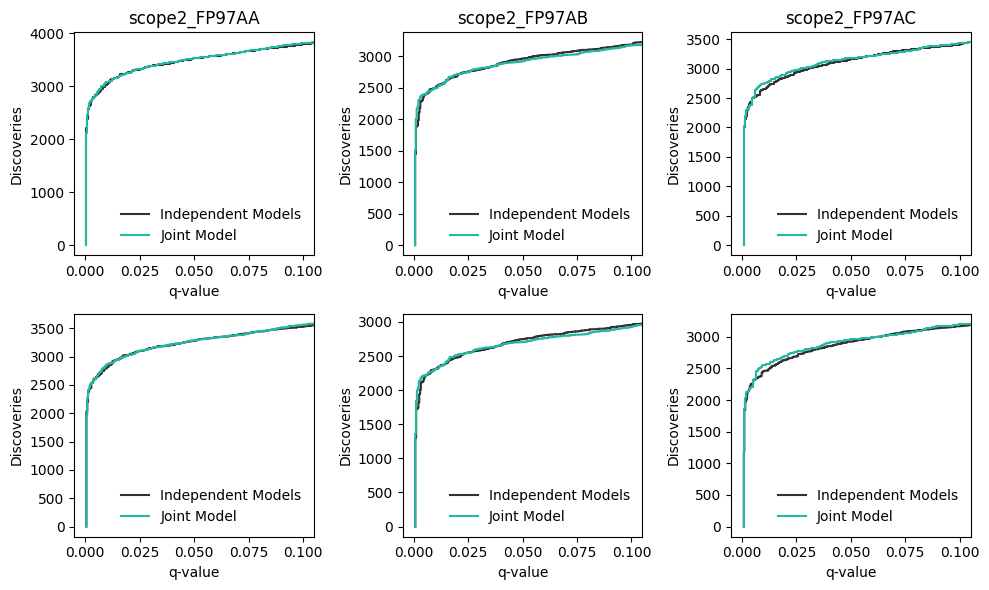

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Put experiments in a logical order:
experiments = list(sep_results.keys())
experiments.sort()

# Plot the perfomance of each:
gain = {}
for col, exp in zip(axs.T, experiments):
    col[0].set_title(exp)
    for ax, level in zip(col, ["psms", "peptides"]):
        # Plot the number of PSMs accepted at each FDR threshold
        sep_results[exp].plot_qvalues(
            level=level, ax=ax, c=colors[0], label="Independent Models"
        )
        joint_results[exp].plot_qvalues(
            level=level, ax=ax, c=colors[1], label="Joint Model"
        )
        ax.legend(frameon=False)

plt.tight_layout()
plt.show()

For these experiments, there appears to be a modest gain in power when the joint modeling strategy is used. This result was expected, because this is a subset of experiments that [benefited from using a static model with Percolator](https://doi.org/10.1021/acs.jproteome.9b00780). 

Let's also take a look at the detected peptides that are shared across the three experiments:

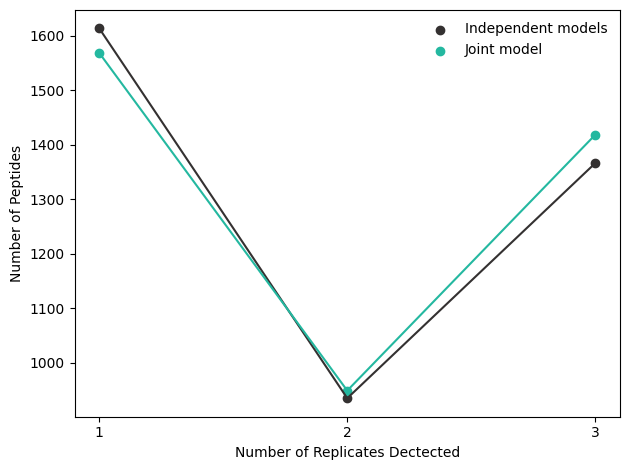

In [9]:
def count_reps(res_dict, fdr=0.01):
    """
    Count the number of replicates in which each peptide is detected.

    Parameters
    ----------
    res_dict : Dict
        A result dictionary from above.
    fdr : float
        The FDR threshold below which to accept peptides.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with the counts for the number of peptides
        detected in a number of replicates.
    """
    peps = {
        k: set(p.peptides["peptide"][p.peptides["mokapot_qvalue"] <= 0.01])
        for k, p in res_dict.items()
    }

    all_peps = peps[list(peps.keys())[0]].union(*peps.values())

    reps = []
    for peptide in all_peps:
        reps.append(sum([peptide in r for r in peps.values()]))

    ret = pd.Series(reps).value_counts().reset_index().sort_values("index")
    ret.columns = ["num_reps", "num_peptides"]
    return ret


sep_reps = count_reps(sep_results)
joint_reps = count_reps(joint_results)

plt.figure()
plt.plot(sep_reps["num_reps"].values, sep_reps["num_peptides"], c=colors[0])
plt.scatter(
    sep_reps["num_reps"].values,
    sep_reps["num_peptides"],
    label="Independent models",
    color=colors[0],
)
plt.plot(
    joint_reps["num_reps"].values, joint_reps["num_peptides"], c=colors[1]
)
plt.scatter(
    joint_reps["num_reps"].values,
    joint_reps["num_peptides"],
    label="Joint model",
    c=colors[1],
)

plt.xticks([1, 2, 3])
plt.xlabel("Number of Replicates Dectected")
plt.ylabel("Number of Peptides")
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

Now we can see that using the joint modeling approach increases the number of PSMs that are detected in across all three experiments. In effect, this leads to fewer missing values in downstream tasks and can have quite a large impact when many experiments are analyzed together.

## Wrapping up

In this vignette we demonstrated how the joint modeling approach available in mokapot can be valuable when analyzing datasets that consist of multiple experiments. It's worth noting that this is particularly beneficial when the total number of PSMs or the number of high-quality PSMs is small, such as is the case with single-cell proteomics experiments we analyzed. For larger experiments, there is typically little to no difference between analyzing the experiments independently or with a joint model.